In [29]:
import torch

In [30]:
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [31]:
import torchvision.models as models

In [32]:
from resnet import ResNet18, ResNet34, ResNet50

In [98]:
print(torch.__version__)

1.7.0


In [103]:
import sys
sys.version

'3.8.17 (default, Jul  5 2023, 20:44:21) [MSC v.1916 64 bit (AMD64)]'

In [33]:
# 클래스 레이블
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 데이터 증강 설정
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomApply([transforms.GaussianBlur(3, sigma=(0.1, 2.0))], p=0.2)
])

# 테스트 데이터는 증강하지 않음
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# CIFAR-10 데이터셋 로드
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

# 9개의 예시 데이터와 레이블 불러오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

Files already downloaded and verified
Files already downloaded and verified


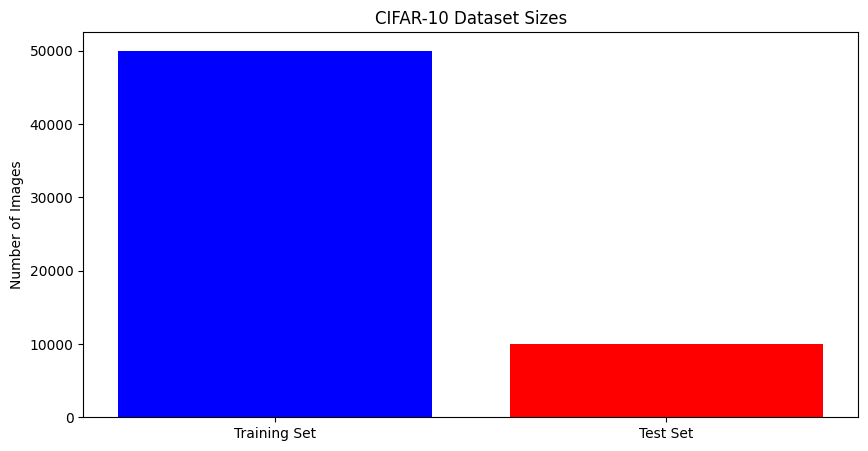

In [69]:
import matplotlib.pyplot as plt

# 데이터셋 크기를 저장할 리스트
dataset_sizes = [trainset_size, testset_size]
dataset_names = ["Training Set", "Test Set"]

plt.figure(figsize=(10, 5))
plt.bar(dataset_names, dataset_sizes, color=['blue', 'red'])
plt.title("CIFAR-10 Dataset Sizes")
plt.ylabel("Number of Images")
plt.show()

In [60]:
trainset_size = len(trainset)
testset_size = len(testset)
trainset_size, testset_size

(50000, 10000)

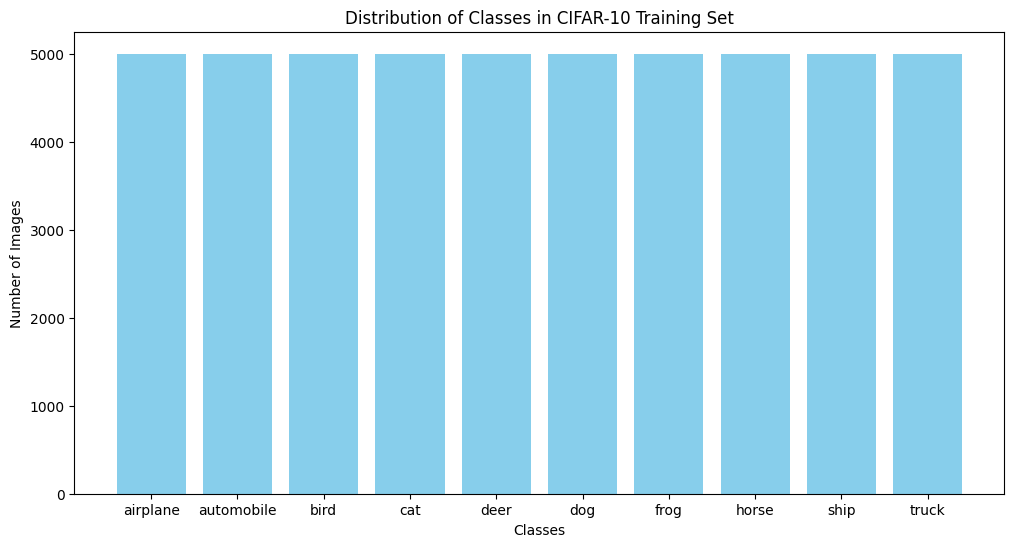

In [71]:
# 각 클래스의 샘플 수를 카운트
class_counts = np.zeros(10)
for _, label in trainset:
    class_counts[label] += 1

# 바 그래프 그리기
plt.figure(figsize=(12, 6))
plt.bar(classes, class_counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in CIFAR-10 Training Set')
plt.show()

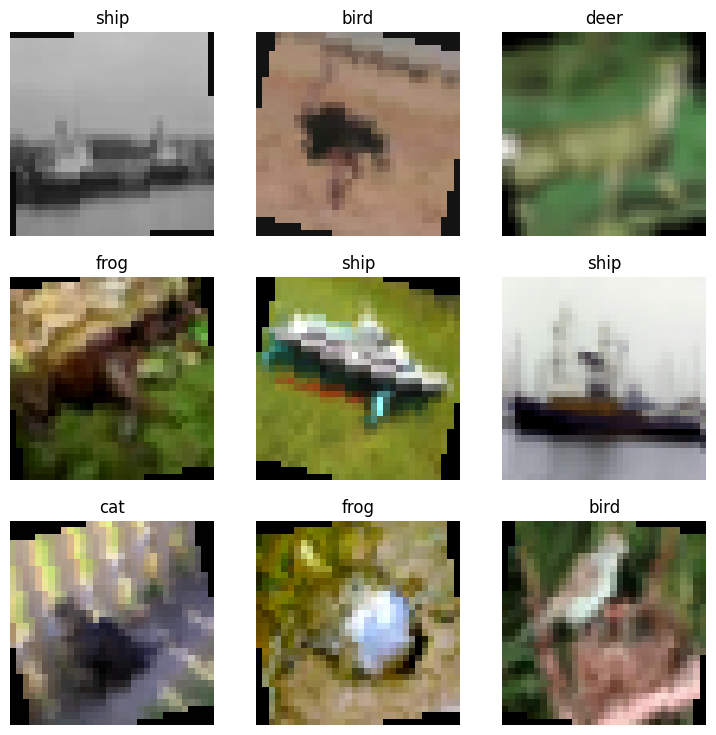

In [5]:
# 이미지를 보여주기 위한 함수
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# 이미지와 레이블을 3x3 그리드로 표시
fig = plt.figure(figsize=(9, 9))
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    imshow(images[i])
    ax.set_title(classes[labels[i]])
plt.show()

In [34]:
# Xavier         
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [35]:
device = 'cuda'
model = ResNet18() #ResNet 18 사용

In [36]:
model.apply(init_weights)
model = model.to(device)

C:\Users\s0101\AppData\Local\Temp\ipykernel_19084\2860853335.py:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


In [89]:
num_epoch = 150

In [37]:
learning_rate = 0.1
model_name = 'model.pth'

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)

train_loss = 0
valid_loss = 0
correct = 0
total_cnt = 0
best_acc = 0

In [38]:
# Simple Learning Rate Scheduler
def lr_scheduler(optimizer, epoch):
    lr = learning_rate
    if epoch >= 50:
        lr /= 10
    if epoch >= 100:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

- 학습 초기에는 높은 학습률을 사용하다가, 일정 에포크를 지난 후에 학습률을 점차 감소시키는 방식을 취함.
- 위와 같은 방식은 학습 초기에 큰 스텝으로 빠르게 최적화 방향을 찾아나가다가, 일정 에포크가 지나면 작은 스텝으로 세밀하게 최적화를 진행한다.
- 학습의 안정성을 높이고, 최종적으로 더 나은 성능의 모델을 얻을 수 있다.

In [17]:
# Train
for epoch in range(num_epoch):
    print(f"====== { epoch+1} epoch of { num_epoch } ======")
    model.train()
    lr_scheduler(optimizer, epoch)
    train_loss = 0
    valid_loss = 0
    correct = 0
    total_cnt = 0
    # Train
    for step, batch in enumerate(trainloader):
        #  input and target
        batch[0], batch[1] = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        
        logits = model(batch[0])
        loss = loss_fn(logits, batch[1])
        loss.backward()
        
        optimizer.step()
        train_loss += loss.item()
        _, predict = logits.max(1)
        
        total_cnt += batch[1].size(0)
        correct +=  predict.eq(batch[1]).sum().item()
        
        if step % 100 == 0 and step != 0:
            print(f"\n====== { step } Step of { len(trainloader) } ======")
            print(f"Train Acc : { correct / total_cnt }")
            print(f"Train Loss : { loss.item() / batch[1].size(0) }")
            
    correct = 0
    total_cnt = 0

====== 1 epoch of 150 ======

====== 100 Step of 1563 ======
Train Acc : 0.15872524752475248
Train Loss : 0.067788265645504

====== 200 Step of 1563 ======
Train Acc : 0.17801616915422885
Train Loss : 0.071415975689888

====== 300 Step of 1563 ======
Train Acc : 0.18615033222591362
Train Loss : 0.06948031485080719

====== 400 Step of 1563 ======
Train Acc : 0.18937032418952618
Train Loss : 0.0659935474395752

====== 500 Step of 1563 ======
Train Acc : 0.19323852295409183
Train Loss : 0.06131206452846527

====== 600 Step of 1563 ======
Train Acc : 0.19873128119800332
Train Loss : 0.06416052579879761

====== 700 Step of 1563 ======
Train Acc : 0.20319186875891584
Train Loss : 0.06371434032917023

====== 800 Step of 1563 ======
Train Acc : 0.21032303370786518
Train Loss : 0.06942717730998993

====== 900 Step of 1563 ======
Train Acc : 0.2153163152053274
Train Loss : 0.0605783648788929

====== 1000 Step of 1563 ======
Train Acc : 0.22081043956043955
Train Loss : 0.06075810268521309

======

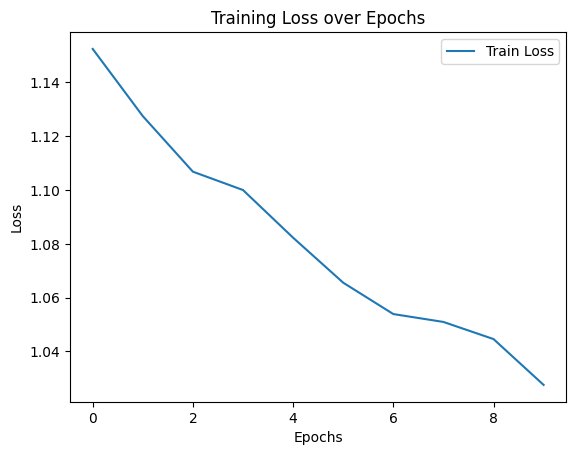

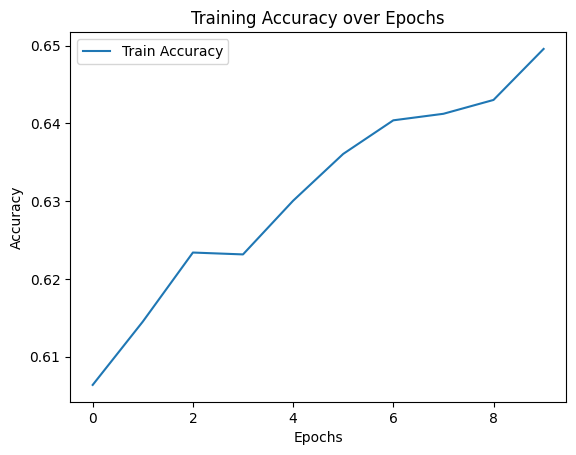

<Figure size 640x480 with 0 Axes>

In [52]:
def plot_train_graph(train_losses, train_accuracies):
    epochs = range(len(train_losses))
    
    # training loss
    plt.plot(train_losses, label="Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss over Epochs")
    plt.legend()
    plt.show()

    # training accuracy
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy over Epochs")
    plt.legend()
    plt.show()

    plt.tight_layout()
    plt.show()

plot_train_graph(train_losses, train_accuracies)

In [22]:
# Test
with torch.no_grad():
    model.eval()
    for step, batch in enumerate(testloader):
        # input and target
        batch[0], batch[1] = batch[0].to(device), batch[1].to(device)
        total_cnt += batch[1].size(0)
        logits = model(batch[0])
        valid_loss += loss_fn(logits, batch[1])
        _, predict = logits.max(1)
        correct += predict.eq(batch[1]).sum().item()
    valid_acc = correct / total_cnt
    print(f"\ntest Acc : { valid_acc }")    
    print(f"test Loss : { valid_loss / total_cnt }")

    if(valid_acc > best_acc):
        best_acc = valid_acc
        torch.save(model, model_name)
        print("Model Saved!")


Valid Acc : 0.8464557564224549
Valid Loss : 0.016919169574975967


In [55]:
def evaluate_saved_model_on_test(model_path, testloader):
    # 저정된 모델 호출
    loaded_model = torch.load(model_path)
    loaded_model = loaded_model.to(device)
    
    total_cnt = 0
    correct = 0
    test_loss = 0.0

    # 모델을  평가 모드로 설정
    loaded_model.eval()
    

    loss_fn = torch.nn.CrossEntropyLoss()

    # 배치단위로 데이터 가져옴
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch[0].to(device), batch[1].to(device)
        
            logits = loaded_model(images)
            
    
            loss = loss_fn(logits, labels)
            test_loss += loss.item()
            
    
            _, predicted = logits.max(1)
            total_cnt += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    
    test_acc = correct / total_cnt
    print(f"Test Accuracy: {test_acc * 100:.2f}%")
    print(f"Test Loss: {test_loss / total_cnt:.4f}")

evaluate_saved_model_on_test(model_name, testloader)

Test Accuracy: 84.72%
Test Loss: 0.0168


- 5시간 30분 소요.

- Cifar10은 다중 클래스 분류 문제로 confusion matrix를 이용하여 보기 쉽게 모델을 평가할 수 있다.
    - 각 클래스가 얼마나 잘 분류되었는지, 어느 클래스에 대해 오분류가 많이 발생했는지 등의 정보를 얻을 수 있다.

C:\Users\s0101\AppData\Local\Temp\ipykernel_19084\3642751863.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  def plot_confusion_matrix(con_mat, labels, title='Confusion Matrix', cmap=plt.cm.get_cmap('Blues'), normalize=False):


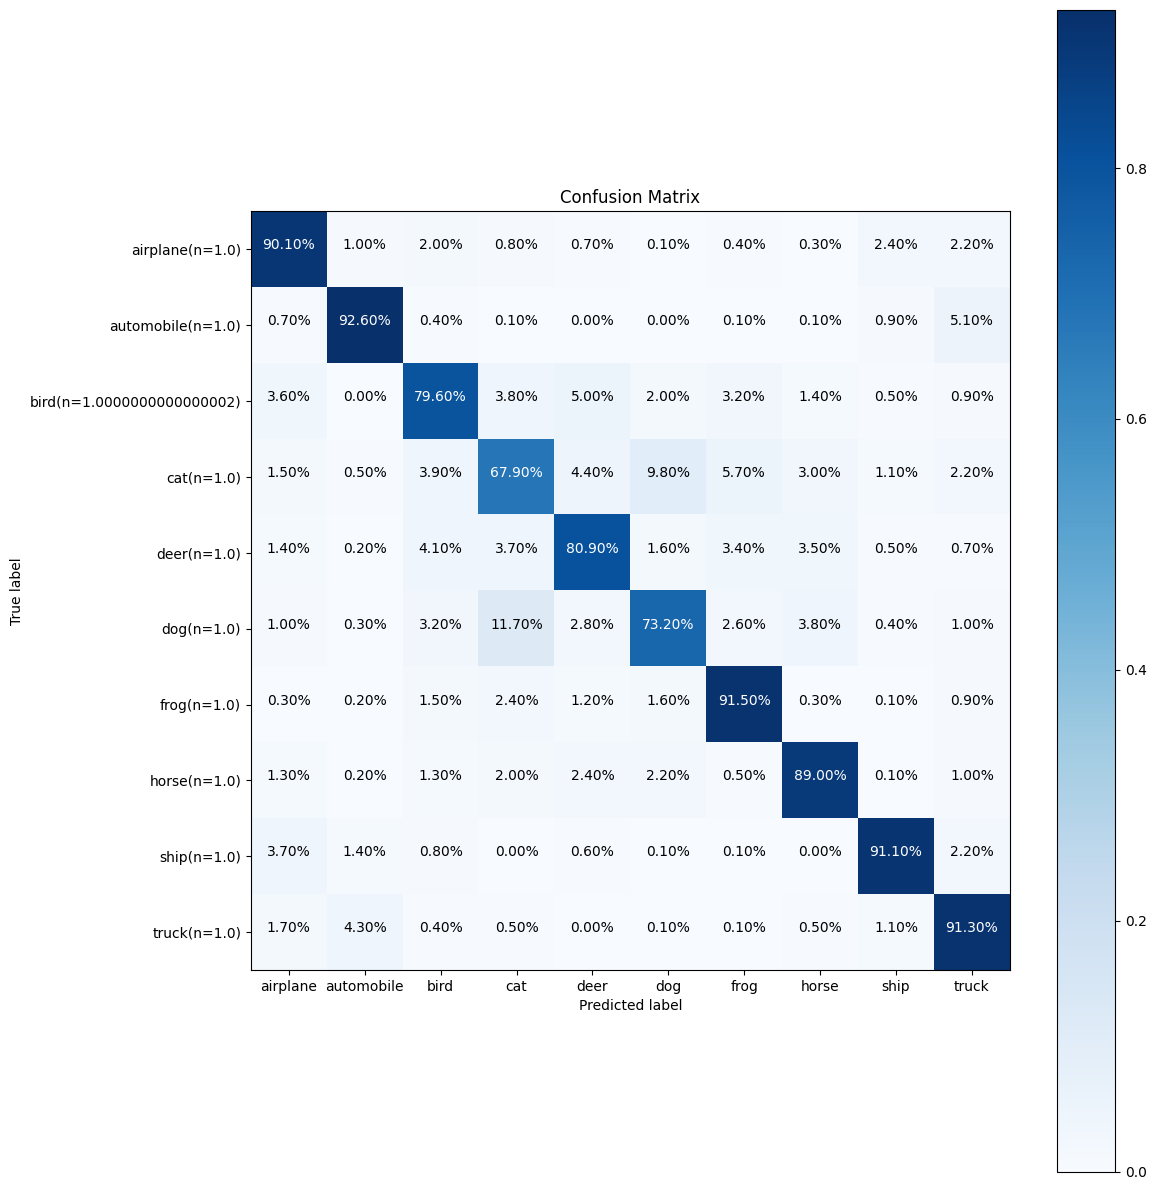

In [70]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(con_mat, labels, title='Confusion Matrix', cmap=plt.cm.get_cmap('Blues'), normalize=False):
    if normalize:
        con_mat = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12, 12))
    plt.imshow(con_mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    marks = np.arange(len(labels))
    nlabels = []
    for k in range(len(con_mat)):
        n = sum(con_mat[k])
        nlabel = '{0}(n={1})'.format(labels[k],n)
        nlabels.append(nlabel)
    plt.xticks(marks, labels)
    plt.yticks(marks, nlabels)

    thresh = con_mat.max() / 2.
    if normalize:
        for i, j in itertools.product(range(con_mat.shape[0]), range(con_mat.shape[1])):
            plt.text(j, i, '{0:.2f}%'.format(con_mat[i, j] * 100), horizontalalignment="center", color="white" if con_mat[i, j] > thresh else "black")
    else:
        for i, j in itertools.product(range(con_mat.shape[0]), range(con_mat.shape[1])):
            plt.text(j, i, str(con_mat[i, j]), horizontalalignment="center", color="white" if con_mat[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# 메인 실행
from sklearn.metrics import confusion_matrix as sklearn_cm

confusion_matrix = sklearn_cm(y_true, y_pred)
plot_confusion_matrix(confusion_matrix, labels=classes, normalize=True)


- Confusion matrix는 분류 모델의 성능을 평가하기 위한 행렬로, 실제 레이블과 모델이 예측한 레이블 간의 관계를 나타냅니다.
- predicted 가 cat 인데 true 는 dog 인 경우 11.7%
- predicted 가 dog 인데 true 는 cat 인 경우 9.8%
    - 다른 label에 비하여 dog와 cat을 예측하는데 어려움을 겪는다는 것을 알 수 있다.

In [42]:
import random

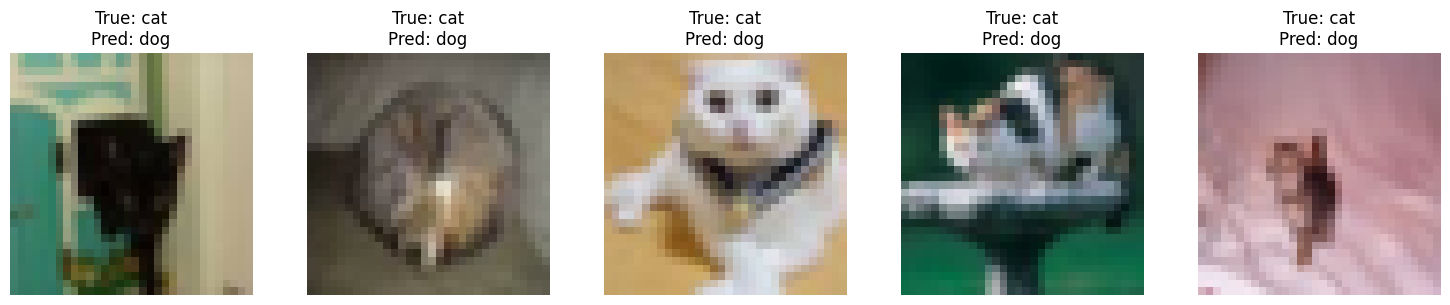

In [44]:
def visualize_predicted_dogs_true_cats(model, testloader, num_images=5):
    incorrect_images = []
    incorrect_labels = []
    incorrect_predictions = []

    # Model evaluation mode
    model.eval()
    
    # Collect incorrect predictions
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            mask = (predicted == classes.index("dog")) & (labels == classes.index("cat"))
            incorrect_images.extend(images[mask].cpu().numpy())
            incorrect_labels.extend(labels[mask].cpu().numpy())
            incorrect_predictions.extend(predicted[mask].cpu().numpy())
    
    # Randomly select some images
    random_indices = random.sample(range(len(incorrect_images)), min(num_images, len(incorrect_images)))
    
    # Plot the images
    fig, axs = plt.subplots(1, len(random_indices), figsize=(3 * len(random_indices), 3))
    for i, idx in enumerate(random_indices):
        image = incorrect_images[idx].transpose((1, 2, 0))  # Convert (C, H, W) to (H, W, C)
        label = classes[incorrect_labels[idx]]
        prediction = classes[incorrect_predictions[idx]]
        axs[i].imshow(image * 0.5 + 0.5)  # Denormalize
        axs[i].set_title(f"True: {label}\nPred: {prediction}")
        axs[i].axis("off")
    plt.tight_layout()
    plt.show()

# Visualize predictions where pred is "dog" and true label is "cat"
visualize_predicted_dogs_true_cats(model, testloader)

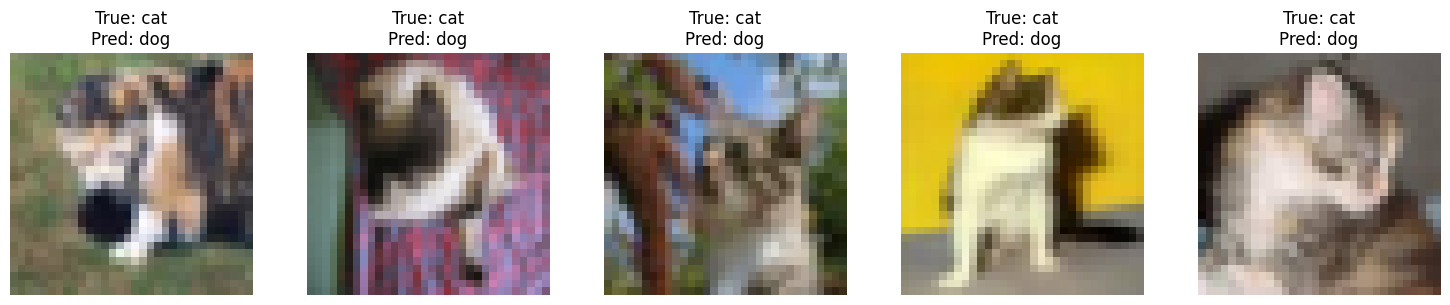

In [45]:
visualize_predicted_dogs_true_cats(model, testloader)

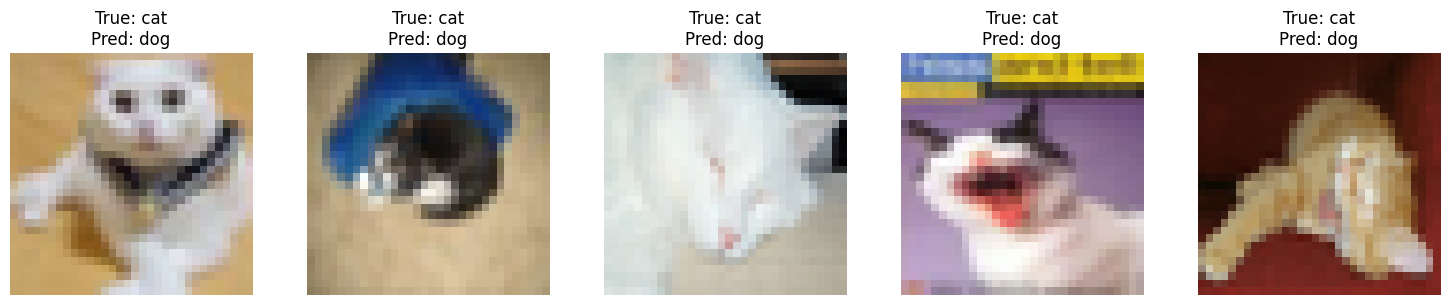

In [46]:
visualize_predicted_dogs_true_cats(model, testloader)

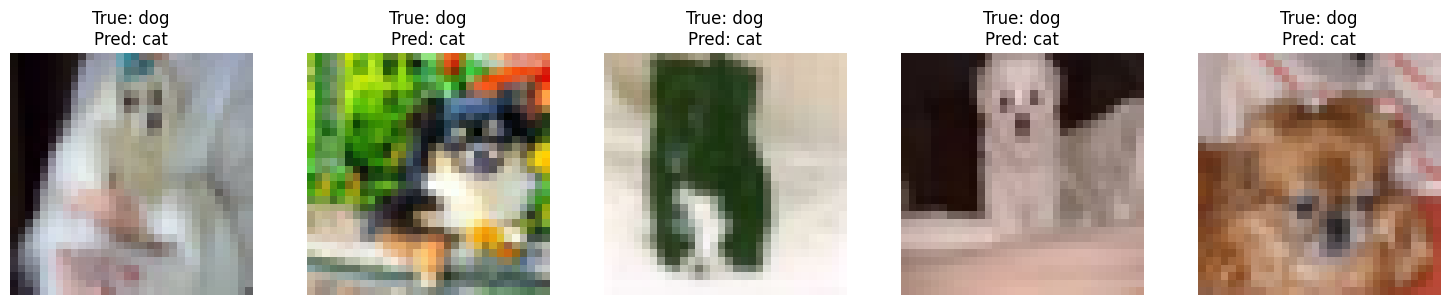

In [47]:
def visualize_predicted_cats_true_dogs(model, testloader, num_images=5):
    incorrect_images = []
    incorrect_labels = []
    incorrect_predictions = []

    # Model evaluation mode
    model.eval()
    
    # Collect incorrect predictions
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            mask = (predicted == classes.index("cat")) & (labels == classes.index("dog"))
            incorrect_images.extend(images[mask].cpu().numpy())
            incorrect_labels.extend(labels[mask].cpu().numpy())
            incorrect_predictions.extend(predicted[mask].cpu().numpy())
    
    # Randomly select some images
    random_indices = random.sample(range(len(incorrect_images)), min(num_images, len(incorrect_images)))
    
    # Plot the images
    fig, axs = plt.subplots(1, len(random_indices), figsize=(3 * len(random_indices), 3))
    for i, idx in enumerate(random_indices):
        image = incorrect_images[idx].transpose((1, 2, 0))  # Convert (C, H, W) to (H, W, C)
        label = classes[incorrect_labels[idx]]
        prediction = classes[incorrect_predictions[idx]]
        axs[i].imshow(image * 0.5 + 0.5)  # Denormalize
        axs[i].set_title(f"True: {label}\nPred: {prediction}")
        axs[i].axis("off")
    plt.tight_layout()
    plt.show()

# Visualize predictions where pred is "cat" and true label is "dog"
visualize_predicted_cats_true_dogs(model, testloader)

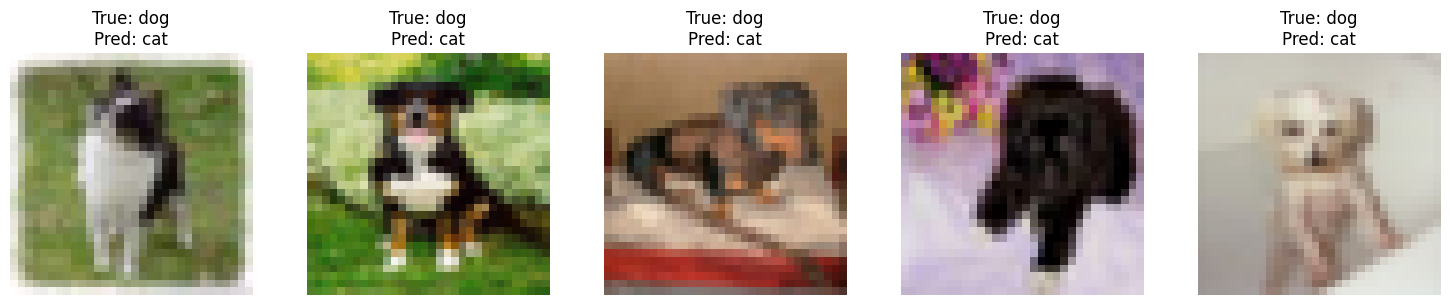

In [48]:
visualize_predicted_cats_true_dogs(model, testloader)

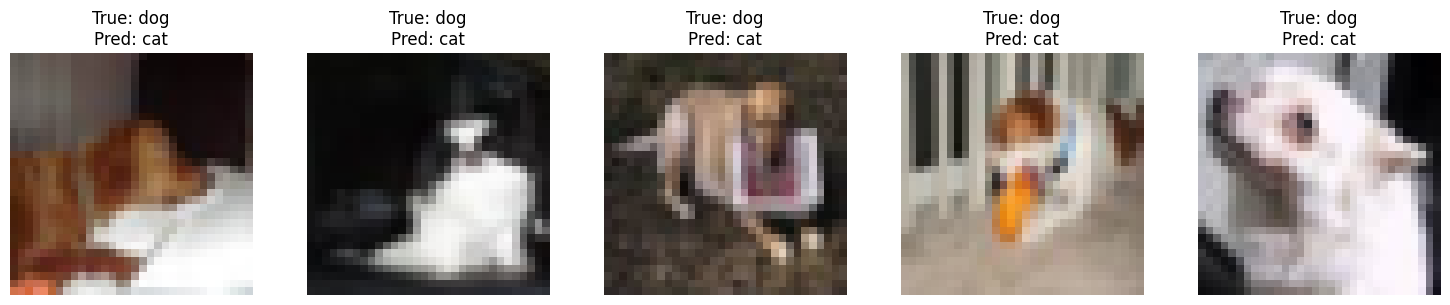

In [49]:
visualize_predicted_cats_true_dogs(model, testloader)

- 주로 예측에 실패한 개와 고양이 class를 시각화하여 살펴본다.
-  EDA, 모델 구현과 시각화 자료 등 전반적인 과정을 바탕으로 예측에 어려움을 겪은 이유에 대해 몇가지 추측이 가능하다.
    - CIFAR-10 데이터셋의 이미지는 32x32 픽셀로, 결과 사진에서도 확인할 수 있듯이 상대적으로 매우 낮은 해상도를 가지고 있다. 때문에 정보 손실이 많이 발생하고 유사한 특징을 가진 두 클래스에서 특히 구별하기 어려웠을 것이다.
    - CIFAR-10은 EDA과정에서 균형잡힌 데이터임을 확인하였지만 Data Augmentation과정을 거치며 특정한 변형이나 포즈의 사진이 많아졌을 가능성이 존재한다. 이 때문에 데이터의 불균형을 발생시켰을 가능성 또한 존재하며 모델이 일반화를 하는 과정에서 어려움을 겪었을 수 있다.
    - 개와 고양이는 네 발로 걷는 동물이고, 털, 귀, 눈, 코 등 유사한 특징을 공유한다. 또한 각 품종에 따라서 특징이 다양하고 유사한 특징을 가지고 있다. 사진에서 인간도 구분하기 어려운 유사한 부분이 많고 이 때문에 모델이 두 클래스를 구분하는 것이 어려웠을 것이다.
    - 변형 및 포즈의 다양성: 'cat'과 'dog' 이미지들은 다양한 변형 (예: 회전, 크기 변화, 위치 변화 등) 과 포즈 (예: 앉아 있음, 누워 있음, 달리는 중, 서있음 등)를 가지고 있음을 확인할 수 있었다. 이러한 변형과 포즈의 다양성은 모델이 두 클래스를 정확하게 구분하는 것이 어려웠을 것이다.
    - 개와 고양이 이미지는 다양한 배경에서 촬영되어있다. 결과사진들에서 확인할 수 있듯이 개는 야외에서 촬영되거나 집 안의 특정 공간, 사람의 품안 등에서 촬영되어있다. 이러한 다양한 배경은 모델이 주요 객체와 배경을 구분하는 데 어려움을 발생시켰을 가능성이 있다.

- 발생하는 문제들에 대한 해결 방법을 생각해보고 조사해본다.
    - 저해상도 문제 : 저해상도 이미지를 고해상도 이미지로 변환하는 작업인 슈퍼 해상도 작업을 진행하여 해결해볼 수 있다. 저해상도 이미지를 고해상도로 매핑하는 함수인 SRCNN (Super-Resolution Convolutional Neural Network), GAN을 슈퍼 해상도 문제에 적용한 SRGAN 등 의 모델을 사용해볼 수 있다. 그러나 고해상도로 이미지를 변환했을 때 더 복잡한 모델이 필요할 수 있기 때문에 사용하는 모델에 대한 분석을 함께 진행할 것을 고려해야 한다.
    - 변형 및 포즈의 다양성 문제 : 추가로 Data Augmentation과정을 진행하여 학습 데이터의 다양성을 높이는 방법으로 해결해볼 수 있다. 그러나 추가로 Data Augmentation과정을 거치며 의도하지 않은 특정한 변형이나 포즈의 사진이 많아질 가능성이 존재하기 때문에 Data를 확인하는 작업이 함께 동반되어야 할것이다.
    - 배경의 다양성 문제 : 이미지 전처리 단계에서 object detection이나 segmentation 기법을 사용하여 판별해야하는 주요 객체를 추출해서 배경을 통일시키는 방법을 적용해볼 수 있다. R-CNN, YOLO 등의 모델을 활용한 object detection, FCN, U-Net 등의 모델을 활용한 segmentation등 다양한 모델을 고려해볼 수 있다.
    - 클래스 간 유사성 문제 : 더 깊은 네트워크나 더 복잡한 아키텍쳐를 사용하여 세밀한 특징을 추출하는 방법을 고려해볼 수 있다. 그러나 데이터의 양이 적고 해상도가 낮은 데이터셋이기 때문에 적절한 Data Augmentation과정과 해상도를 높이는 작업이 동반되어야 할 것이라 예상된다. 또한 미리 훈련된 모델의 가중치를 사용하는 transfer Learning 을 수행해 볼 수 있다.
    - 데이터의 양이 적은 문제 : Generative Adversarial Networks (GANs)와 같은 생성 모델을 사용하여 더 많은 데이터를 생성하고 추가하여 보다 큰 데이터셋으로 모델을 학습시키는 방법을 고려해볼 수 있다.

In [72]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [74]:
# 모델 불러오기
loaded_model = torch.load(model_name)
loaded_model = loaded_model.to(device)
loaded_model.eval()

all_targets = []
all_predictions = []

with torch.no_grad():
    for batch in testloader:
        inputs, targets = batch[0].to(device), batch[1].to(device)
        logits = loaded_model(inputs)
        _, predictions = logits.max(1)
        
        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

# 메트릭 계산
accuracy = accuracy_score(all_targets, all_predictions)
precision = precision_score(all_targets, all_predictions, average=None)  # 클래스별 정밀도
recall = recall_score(all_targets, all_predictions, average=None)  # 클래스별 재현율
f1 = f1_score(all_targets, all_predictions, average=None)  # 클래스별 F1-점수

# 결과 출력
print(f"Accuracy: {accuracy}")
print(f"Class-wise Precision: {precision}")
print(f"Class-wise Recall: {recall}")
print(f"Class-wise F1 Score: {f1}")

Accuracy: 0.8472
Class-wise Precision: [0.85565052 0.91956306 0.81893004 0.73089343 0.8255102  0.80705623
 0.85037175 0.8734053  0.92769857 0.84930233]
Class-wise Recall: [0.901 0.926 0.796 0.679 0.809 0.732 0.915 0.89  0.911 0.913]
Class-wise F1 Score: [0.87773989 0.9227703  0.80730223 0.70399171 0.81717172 0.76769795
 0.88150289 0.88162457 0.91927346 0.88      ]


- 추가로 CIFAR-10 데이터셋에 대한 ResNet18의 성능을 분석해보았다.
    - Accuracy: 84.72%
        모델은 전체 테스트 데이터 중 약 84.72%를 올바르게 분류했음을 알 수 있다.
    - Class-wise Precision:
        가장 높은 Precision은 9번째 클래스(91.9%, 'ship')에서, 가장 낮은 Precision은 3번째 클래스(73.1%, 'cat')에서 확인할 수 있다.
        'cat' 클래스에서 모델이 다른 클래스의 이미지를 'cat'으로 잘못 분류하는 경우가 상대적으로 많았다.
    - Class-wise Recall:
        가장 높은 Recall은 1번째 클래스(92.6%, 'car')에서, 가장 낮은 Recall은 5번째 클래스(73.2%, 'dog')에서 관찰된다.
        'dog' 클래스가 가장 낮은 Recall 값을 가지는 것을 통해 실제 'dog' 클래스의 이미지 중 일부가 다른 클래스로 잘못 분류되었다는 것을 알 수 있다.
    - Class-wise F1 Score:
        F1 Score는 Precision과 Recall의 조화 평균이므로 두 값의 균형을 나타낸다.
        가장 높은 F1 Score는 1번째 클래스(92.3%, 'car')에서, 가장 낮은 F1 Score는 3번째 클래스(70.4%, 'cat')에서 관찰된다. <br>'cat'클래스가 예측한 것 중 실제로 해당 클래스가 아닌 케이스가 많고, (특정 클래스로 잘못 분류하는 경우가 많다) 또한, 실제 해당 클래스의 샘플 중 많은 수가 다른 클래스로 잘못 분류되었다는 것을 확인할 수 있었다.(해당 클래스를 놓치는 경우가 많다.)
> 모델이 'cat'클래스를 정확하게 예측하는데에 가장 어려움을 겪고 있다는 것을 알 수 있다.
           

In [75]:
correct = 0
total_cnt = 0

with torch.no_grad():
    for batch in testloader:
        inputs, targets = batch[0].to(device), batch[1].to(device)
        logits = loaded_model(inputs)
        _, predictions = logits.max(1)
        
        # 'cat'과 'dog'를 제외한 데이터만 고려
        selected_indices = (targets != 3) & (targets != 5)
        
        correct += predictions[selected_indices].eq(targets[selected_indices]).sum().item()
        total_cnt += selected_indices.sum().item()

# Accuracy 계산
accuracy_without_cat_dog = correct / total_cnt

print(f"Accuracy (without 'cat' and 'dog'): {accuracy_without_cat_dog}")

Accuracy (without 'cat' and 'dog'): 0.882625


- 낮은 정확도를 보이는 개 고양이 class를 제외한 Accuracy를 확인한다.
    - 88% 의 정확도를 확인할 수 있다.

## 성능향상 (transfer)

In [92]:
# ResNet18 모델 불러오기 및 전이 학습 설정
net = resnet18(pretrained=True)

# CIFAR-10은 10개의 클래스가 있으므로 출력 레이어를 10으로 변경
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 10)

# 모델을 GPU로 이동
net = net.to(device)

# 학습률 및 최적화 설정
learning_rate = 0.1
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()

# 얼리 스톱 관련 변수 설정
patience = 10
early_stopping_counter = 0
best_loss = float('inf')

In [93]:
# 학습
train_losses = []
train_accuracies = []

for epoch in range(num_epoch):
    print(f"====== { epoch+1} epoch of { num_epoch } ======")
    net.train()
    epoch_train_loss = 0
    correct = 0
    total_cnt = 0
    
    for step, batch in enumerate(trainloader):
        # Input and target
        batch[0], batch[1] = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        
        logits = net(batch[0])
        loss = loss_fn(logits, batch[1])
        loss.backward()
        
        optimizer.step()
        epoch_train_loss += loss.item()
        _, predict = logits.max(1)
        
        total_cnt += batch[1].size(0)
        correct +=  predict.eq(batch[1]).sum().item()
        
        if step % 100 == 0 and step != 0:
            print(f"\n====== { step } Step of { len(trainloader) } ======")
            print(f"Train Acc : { correct / total_cnt }")
            print(f"Train Loss : { loss.item() / batch[1].size(0) }")
    
    # 각 에폭의 트레이닝 결과 저장
    train_losses.append(epoch_train_loss / len(trainloader))
    train_accuracies.append(correct / total_cnt)

    # 검증
    net.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for batch in testloader:
            inputs, labels = batch[0].to(device), batch[1].to(device)
            outputs = net(inputs)
            loss = loss_fn(outputs, labels)
            valid_loss += loss.item()

    valid_loss /= len(testloader)
    
    # 얼리 스톱 체크
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(net, 'transfer_model.pth')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping!")
        break

====== 1 epoch of 150 ======

====== 100 Step of 1563 ======
Train Acc : 0.10643564356435643
Train Loss : 0.07353014498949051

====== 200 Step of 1563 ======
Train Acc : 0.12064676616915423
Train Loss : 0.07414816319942474

====== 300 Step of 1563 ======
Train Acc : 0.12489617940199335
Train Loss : 0.07238037139177322

====== 400 Step of 1563 ======
Train Acc : 0.1302213216957606
Train Loss : 0.07431899756193161

====== 500 Step of 1563 ======
Train Acc : 0.13529191616766467
Train Loss : 0.0695759505033493

====== 600 Step of 1563 ======
Train Acc : 0.14002703826955074
Train Loss : 0.06791174411773682

====== 700 Step of 1563 ======
Train Acc : 0.14457025677603424
Train Loss : 0.06194211542606354

====== 800 Step of 1563 ======
Train Acc : 0.15039794007490637
Train Loss : 0.06959888339042664

====== 900 Step of 1563 ======
Train Acc : 0.15413429522752498
Train Loss : 0.06871410459280014

====== 1000 Step of 1563 ======
Train Acc : 0.15949675324675325
Train Loss : 0.06406445801258087

=

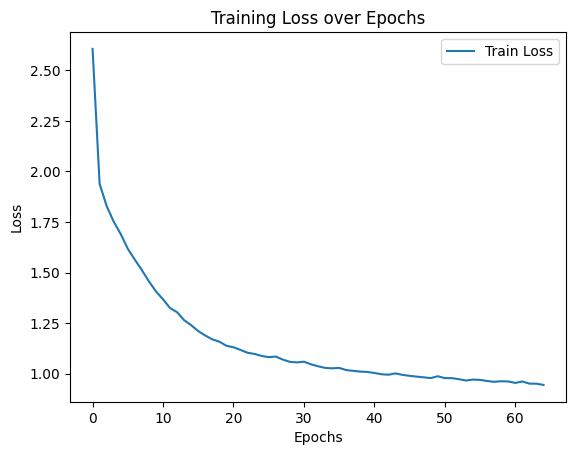

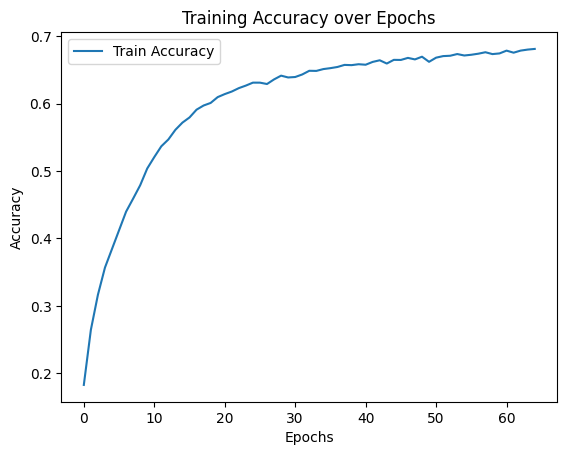

<Figure size 640x480 with 0 Axes>

In [94]:
plot_train_graph(train_losses, train_accuracies)

- 2시간 30분 소요 , Early stopping

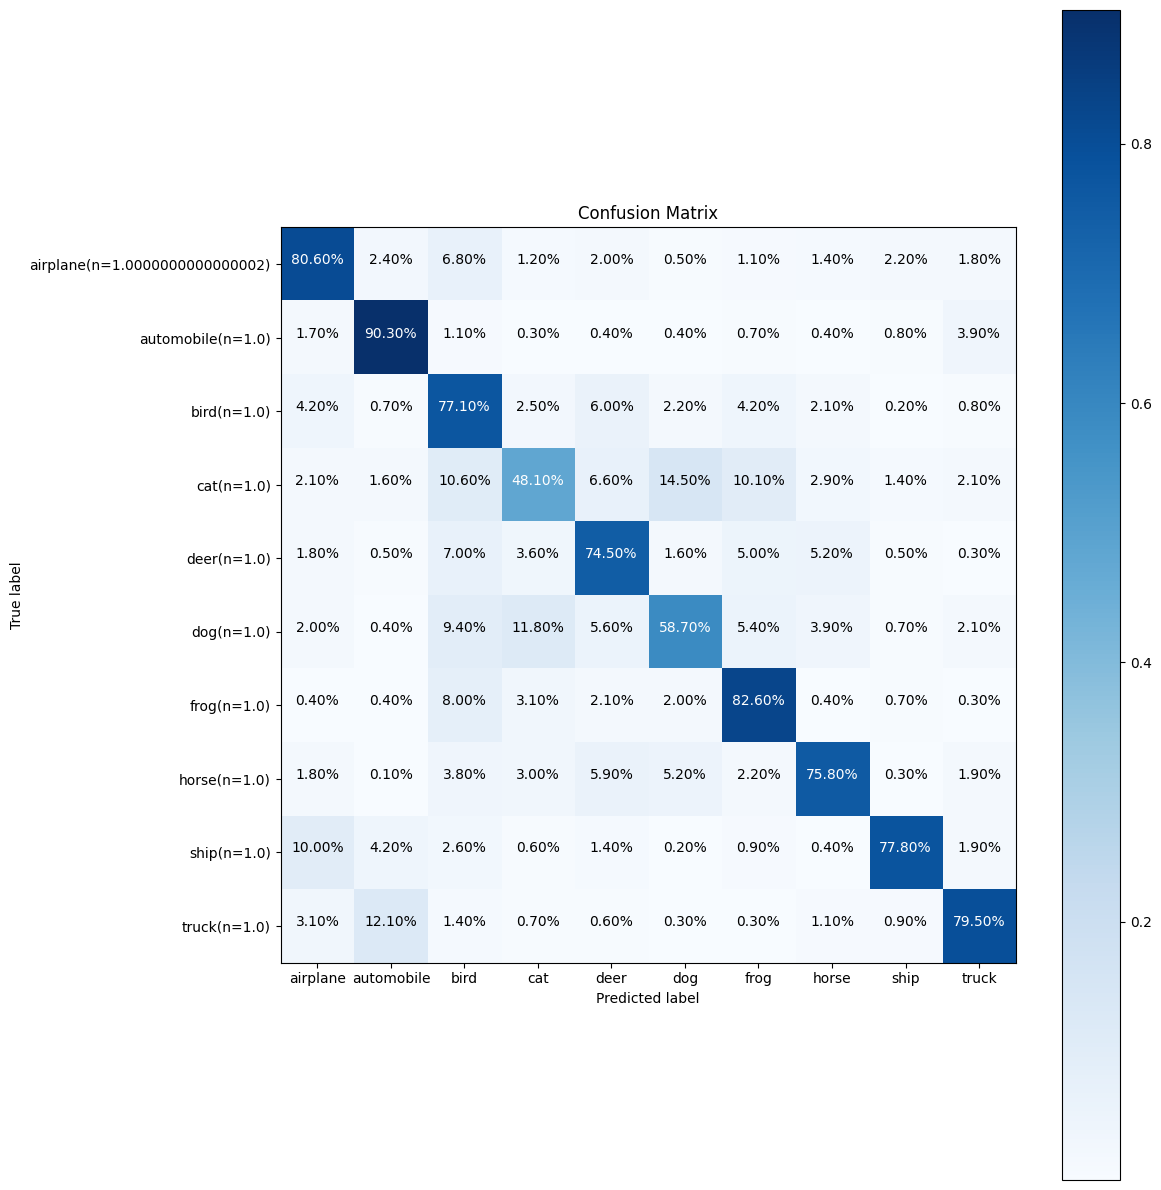

In [95]:
# 트랜스퍼 학습 모델 불러오기
loaded_model = torch.load('transfer_model.pth')
loaded_model = loaded_model.to(device)
loaded_model.eval()

all_targets = []
all_predictions = []

# 테스트 데이터셋에서 예측 생성
with torch.no_grad():
    for batch in testloader:
        inputs, targets = batch[0].to(device), batch[1].to(device)
        logits = loaded_model(inputs)
        _, predictions = logits.max(1)
        
        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

# sklearn를 사용하여 혼동 행렬 생성
confusion_matrix = sklearn_cm(all_targets, all_predictions)

# 혼동 행렬 시각화
plot_confusion_matrix(confusion_matrix, labels=classes, normalize=True)

In [96]:
# 모델 불러오기
loaded_model = torch.load('transfer_model.pth')
loaded_model = loaded_model.to(device)
loaded_model.eval()

all_targets = []
all_predictions = []

with torch.no_grad():
    for batch in testloader:
        inputs, targets = batch[0].to(device), batch[1].to(device)
        logits = loaded_model(inputs)
        _, predictions = logits.max(1)
        
        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

# 메트릭 계산
accuracy = accuracy_score(all_targets, all_predictions)
precision = precision_score(all_targets, all_predictions, average=None)  # 클래스별 정밀도
recall = recall_score(all_targets, all_predictions, average=None)  # 클래스별 재현율
f1 = f1_score(all_targets, all_predictions, average=None)  # 클래스별 F1-점수

# 결과 출력
print(f"Accuracy: {accuracy}")
print(f"Class-wise Precision: {precision}")
print(f"Class-wise Recall: {recall}")
print(f"Class-wise F1 Score: {f1}")

Accuracy: 0.745
Class-wise Precision: [0.74837512 0.80124224 0.60328638 0.64218959 0.70884872 0.68574766
 0.73422222 0.80982906 0.90994152 0.84038055]
Class-wise Recall: [0.806 0.903 0.771 0.481 0.745 0.587 0.826 0.758 0.778 0.795]
Class-wise F1 Score: [0.7761194  0.84908322 0.67690957 0.55002859 0.72647489 0.6325431
 0.77741176 0.78305785 0.83881402 0.81706064]


- 학습이 완료되기까지의 시간은 현저히 줄었다. 2시간 30분 < 5시간 30분
> 문제점 및 해결방안
- 데이터의 양이 상대적으로 작다고 판단되는 바, 트랜스퍼 학습의 이점을 제대로 활용하기 어렵다고 판단할 수 있다.
    - 데이터 증강 기법들을 조절하거나 다른 기법들을 고려해본다.
- 학습률이 이전 학습 그대로 0.1로 설정되었다. 트랜스퍼 학습에서는 사전 훈련된 가중치를 미세 조정하는 것이 중요한데, 이러한 높은 학습률이 가중치를 너무 빠르게 변경하는 문제가 발생했을 수 있다.
    - 학습률을 조절하여 더 낮은 값으로 시작해볼 수 있다.
-  50 에포크와 100 에포크 후에 학습률을 10으로 나누는 방식의 스케줄링이 그대로 사용되었다. 미세 조정이 필요하다.
    - 학습률을 일정한 스텝마다 감소시키는 Step Decay  방법, 학습률이 먼저 증가하다가, 절반 경과 후 감소하는 전략을 사용하는 One-cycle policy등 의 방법을 적용해본다.
